# 导入相关库

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.applications.xception import preprocess_input 
from keras.preprocessing.image import *
import numpy as np
from keras.models import load_model
import h5py
from  keras.optimizers import*
from keras.models import Sequential,Model
import pandas as pd

Using TensorFlow backend.


# 模型构建

In [2]:
image_size=(299,299)
width = image_size[0]
height = image_size[1]
input_tensor = Input((height, width, 3))
x = input_tensor
x = Lambda(xception.preprocess_input)(x)
model_xce = Xception(input_tensor=x, weights='imagenet', include_top=False)


for layers in model_xce.layers:
    layers.trainable = False
    
x = GlobalAveragePooling2D()(model_xce.output)
x = Dropout(0.25)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)
model = Model(model_xce.input, x)

## 模型编译

In [3]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# 准备数据

In [4]:
from scipy import misc
from tqdm import tqdm
np.random.seed(20171001)

n = 25000
X = np.zeros((n, 299, 299, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
    X[i] = misc.imresize(misc.imread('../train/cat.%d.jpg' % i), image_size)
    X[i+n//2] = misc.imresize(misc.imread('../train/dog.%d.jpg' % i),image_size)

y[n//2:] = 1

100%|██████████| 12500/12500 [03:44<00:00, 55.78it/s]


# 测试集和训练集的划分

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [8]:
with h5py.File('train_data.h5') as h:
    h.create_dataset("train",data=X_train)
    h.create_dataset("valid", data=X_valid)
    h.create_dataset("y_train", data=y_train)
    h.create_dataset("y_valid", data=y_valid)

In [7]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
save_model = ModelCheckpoint('xception{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid),
          callbacks=[early_stopping,save_model])

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 1836s - loss: 0.1017 - acc: 0.9688 - val_loss: 0.0315 - val_acc: 0.9912
Epoch 2/20
22500/22500 [==============================] - 1833s - loss: 0.0617 - acc: 0.9788 - val_loss: 0.0269 - val_acc: 0.9912
Epoch 3/20
22500/22500 [==============================] - 1833s - loss: 0.0592 - acc: 0.9798 - val_loss: 0.0239 - val_acc: 0.9920
Epoch 4/20
22500/22500 [==============================] - 1833s - loss: 0.0577 - acc: 0.9812 - val_loss: 0.0222 - val_acc: 0.9916
Epoch 5/20
22500/22500 [==============================] - 1833s - loss: 0.0551 - acc: 0.9803 - val_loss: 0.0220 - val_acc: 0.9928
Epoch 6/20
22500/22500 [==============================] - 1833s - loss: 0.0474 - acc: 0.9836 - val_loss: 0.0216 - val_acc: 0.9908
Epoch 7/20
22500/22500 [==============================] - 1833s - loss: 0.0492 - acc: 0.9832 - val_loss: 0.0202 - val_acc: 0.9916
Epoch 8/20
22500/22500 [=================

In [8]:
json_string = model.to_json()
open('xception.json','w').write(json_string)

72783

In [9]:
import matplotlib.pyplot as plt

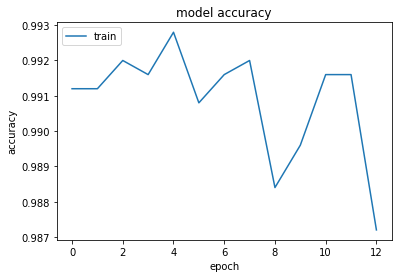

In [10]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

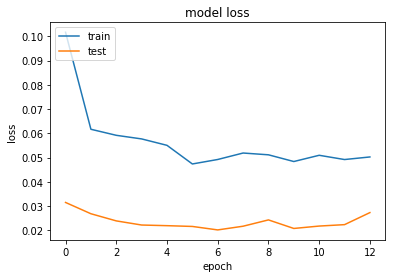

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 预测结果

In [17]:
# 加载最佳模型

In [ ]:
model = model_from_json(open('xception.json').read())
model.load_weights('xception06-0.02.h5')

In [20]:
n = 25000
filenames = os.listdir('../test')
file_ob_path = [os.path.join('../test',file) for file in filenames]
n = len(file_ob_path)

X_test = np.zeros((n, 299, 299, 3), dtype=np.uint8)


for i in tqdm(range(n)):
    X_test[i] = misc.imresize(misc.imread(file_ob_path[i]), (299,299))

100%|██████████| 12500/12500 [01:49<00:00, 114.63it/s]


In [23]:
y_pred = model.predict(X_test,batch_size=16, verbose=1)

12500/12500 [==============================] - 1057s  


In [24]:
y_pred = y_pred.clip(min=0.005, max=0.995)
_id = [int(i.split('.')[0]) for i in filenames]

In [26]:
import pandas as pd

In [27]:
df = pd.DataFrame({'id':_id,'label':y_pred.squeeze()})
df = df.sort_values(by='id')
df.to_csv('sample_submission_xception.csv',index=False)

In [ ]:
# 结果0.04881

# fine-tune

In [28]:
model = model_from_json(open('xception.json').read())
model.load_weights('xception06-0.02.h5')

In [ ]:
with h5py.File('train_data.h5', 'r') as h:
    X_train = np.array(h['train'])
    y_train = np.array(h['y_train'])
    X_valid = np.array(h['valid'])
    y_valid = np.array(h['y_valid'])

In [16]:
#list(zip([x.name for x in model.layers], range(len(model.layers))))

In [29]:
for layer in model.layers[:106]:
    layer.trainable = False
for layer in model.layers[106:]:
    layer.trainable = True

In [30]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, 
                            mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
save_model = ModelCheckpoint('Xception_fine_tune{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
optimizer=Adam(0.001)
model.compile(optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
history_1 = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid),
                      callbacks=[early_stopping,auto_lr,save_model])

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 2390s - loss: 0.0545 - acc: 0.9812 - val_loss: 0.0243 - val_acc: 0.9920
Epoch 2/10
22500/22500 [==============================] - 2384s - loss: 0.0304 - acc: 0.9895 - val_loss: 0.0215 - val_acc: 0.9908
Epoch 3/10
22500/22500 [==============================] - 2384s - loss: 0.0234 - acc: 0.9921 - val_loss: 0.0142 - val_acc: 0.9932
Epoch 4/10
22500/22500 [==============================] - 2383s - loss: 0.0168 - acc: 0.9940 - val_loss: 0.0142 - val_acc: 0.9952
Epoch 5/10
22500/22500 [==============================] - 2383s - loss: 0.0121 - acc: 0.9955 - val_loss: 0.0388 - val_acc: 0.9884
Epoch 6/10
22500/22500 [==============================] - 2383s - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0217 - val_acc: 0.9924
Epoch 7/10
22500/22500 [==============================] - 2384s - loss: 0.0123 - acc: 0.9970 - val_loss: 0.0129 - val_acc: 0.9944
Epoch 8/10
22500/22500 [=================

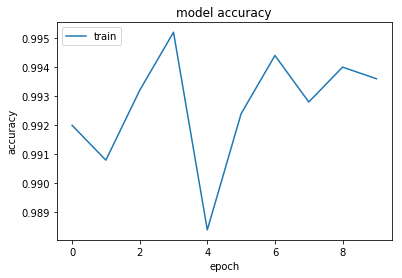

In [33]:
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

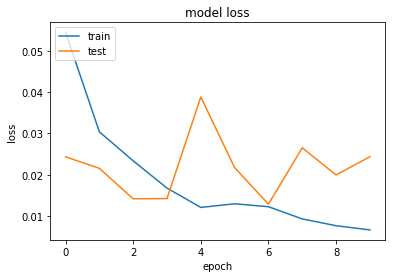

In [34]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# 加载最佳模型

In [36]:
model = model_from_json(open('xception.json').read())
model.load_weights('Xception_fine_tune06-0.01.h5')

In [37]:
y_pred = model.predict(X_test,batch_size=16, verbose=1)

12500/12500 [==============================] - 1057s  


In [39]:
y_pred = y_pred.clip(min=0.005, max=0.995)
_id = [int(i.split('.')[0]) for i in filenames]

In [40]:
df = pd.DataFrame({'id':_id,'label':y_pred.squeeze()})
df = df.sort_values(by='id')
df.to_csv('sample_submission_xception_fn.csv',index=False)

In [ ]:
# 0.04266